In [55]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import os

In [56]:
#load the class labels our YOLO model was trained on
labelsPath = '../data/names/obj.names'
LABELS = open(labelsPath).read().strip().split("\n")

In [57]:
#load weights and cfg
weightsPath = '../data/weights/' + 'crop_weed_detection.weights'
configPath = '../data/cfg/crop_weed.cfg'

In [58]:
#color selection for drawing bbox
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),dtype="uint8")

In [59]:
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

[INFO] loading YOLO from disk...


In [261]:
#load our input image and grab its spatial dimensions
image = cv2.imread('../data/images/test_6.jpg')
(H, W) = image.shape[:2]

In [262]:
#parameters
confi_thresh = 0.5
thresh = 0.5

1
0
1
0


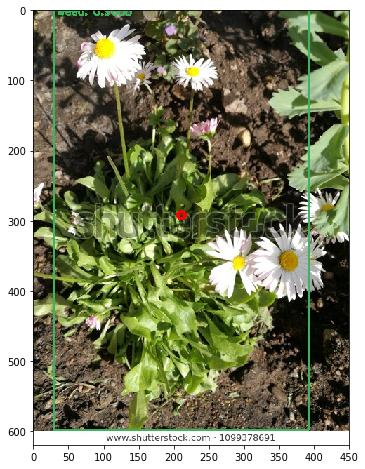

In [263]:
#determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

#makeing blob image for the net input
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (512, 512),swapRB=True, crop=False)

#set the net input
net.setInput(blob)

#forward the input and get the output
outlayers = net.forward(ln)

#true boxes with high confidance
boxes = []
confidances = []
classIDs = []

#unkown objects
unkownBoxes = []
unkownConfidances = []
unkownClassID = []

#iterate over the output layers
for out in outlayers:

	#itrate over the output grid vector
	for grid in out:
		
		#get the confidance of the two classes 0:Crops and 1:Weeds
		#The Yolov3 grid vector contians |x|y|w|h|Pc|class1 Predection|class2 Predection|....etc 
		#Taking the last two items on the vector gives us the predection of out classes
		scores = grid[5:]

		#get the indicaes of the max predection
		predicted_class = np.argmax(scores)
		
		#get the predection
		predect = scores[predicted_class]

		if predect > confi_thresh:

			#rescale the x,y,w and h to the image scale
			box = grid[0:4] * np.array([W, H, W, H])
			(centerX, centerY, width, height) = box.astype("int")
			cv2.circle(image, (centerX,centerY) , 5, (0, 0, 255) , 4)
			#use the center (x, y)-coordinates to derive the top and
			#and left corner of the bounding box
			x = int(centerX - width / 2)
			y = int(centerY - height / 2)

			#update our list of bounding box coordinates, confidences,
			#and class IDs
			boxes.append([x, y, int(width), int(height)])
			confidances.append(float(predect))
			classIDs.append(predicted_class)
		elif predect > 0.1:

			box = grid[0:4] * np.array([W, H, W, H])
			(centerX, centerY, width, height) = box.astype("int")
			cv2.circle(image, (centerX,centerY) , 5, (255, 0, 0) , 4)
			#use the center (x, y)-coordinates to derive the top and
			#and left corner of the bounding box
			x = int(centerX - width / 2)
			y = int(centerY - height / 2)

			#update our list of bounding box coordinates, confidences,
			#and class IDs
			unkownBoxes.append([x, y, int(width), int(height)])
			unkownConfidances.append(float(predect))
			unkownClassID.append(predicted_class)


#apply non-maxima suppression to suppress weak, overlapping bounding
#boxes
print(len(boxes))
print(len(unkownBoxes))

true_boxes = cv2.dnn.NMSBoxes(boxes, confidances, confi_thresh, thresh)
object_boxes = cv2.dnn.NMSBoxes(unkownBoxes, unkownConfidances, 0, thresh)

print(len(true_boxes))
print(len(object_boxes))



if len(true_boxes) > 0:
	#loop over the indexes we are keeping
	for i in true_boxes.flatten():
		#extract the bounding box coordinates
		(x, y) = (boxes[i][0], boxes[i][1])
		(w, h) = (boxes[i][2], boxes[i][3])

		#draw a bounding box rectangle and label on the image
		color = [int(c) for c in COLORS[classIDs[i]]]
		cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
		text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
		cv2.putText(image, text, (x + 5, y + 20), cv2.FONT_HERSHEY_SIMPLEX,0.5, color, 2)

if len(object_boxes) > 0:
	#loop over the indexes we are keeping
	for i in object_boxes.flatten():
		#extract the bounding box coordinates
		(x, y) = (unkownBoxes[i][0], unkownBoxes[i][1])
		(w, h) = (unkownBoxes[i][2], unkownBoxes[i][3])

		#draw a bounding box rectangle and label on the image
		color = [int(c) for c in COLORS[unkownClassID[i]]]
		cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
		text = "{}: {:.4f}".format(LABELS[unkownClassID[i]], unkownConfidances[i])
		cv2.putText(image, text, (x + 5, y + 20), cv2.FONT_HERSHEY_SIMPLEX,0.5, color, 2)


det = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,8))
plt.imshow(det)



In [69]:
# #save detected image 
# path = 'detection.jpeg'#change if you want
# det = cv2.cvtColor(det,cv2.COLOR_RGB2BGR)
# cv2.imwrite(path,det)

True